# Bank Loan Default Risk Analysis (EDA + XGBoost)

This project analyzes loan application data to understand the key factors that influence default risk. Using structured exploratory data analysis (EDA) followed by machine learning modeling, we aim to identify patterns and predict loan defaults effectively.

## Project Goals:
1. Analyze loan applicant data and understand trends
2. Handle missing data, outliers, and imbalances
3. Perform univariate, bivariate, and correlation analysis
4. Build a predictive model using XGBoost


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
app_data_path = '/content/drive/MyDrive/Projects/Bank Loan Project Updated 2025/Q_application_data.csv'
app_df = pd.read_csv(app_data_path, on_bad_lines='skip')


## Step 1: Load the Data

The loan application and previous application datasets are loaded into pandas DataFrames. This allows the data to be read into memory and prepared for exploration. Structural inconsistencies, such as malformed rows, are handled during this step to prevent read-time errors.


### Import Libraries

Loads the pandas library, which is used to handle structured data like CSV files.
on_bad_lines='skip': This tells pandas to ignore and skip rows that are corrupted, meaning they have more columns than expected. This prevents the code from crashing on bad formatting.
Loads your second dataset (previous applications) without any error-handling — which means it’s expected to be clean.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Load Data

In [ ]:
app_df = pd.read_csv('Q_application_data.csv', on_bad_lines='skip')
prev_app_df = pd.read_csv('Q_previous_application.csv')

## Step 2: Preview and Inspect Data

A preview of the dataset is displayed, and the shape and data types of the columns are reviewed. This provides an understanding of the number of features, their types (numeric or categorical), and the general structure of the dataset.






1. `head()`  
   - Displays the first 5 rows of the dataset.  
   - Helps understand what each column contains (e.g., gender, income, credit).

2. `shape`  
   - Returns the number of rows and columns in the format (rows, columns).

3. `dtypes.value_counts()`  
   - Tells how many columns are of each type:  
     - `int64`, `float64`: numeric  
     - `object`: categorical (like gender, job type)


In [ ]:
# View first 5 rows
app_df.head()

# Check number of rows and columns
app_df.shape

# Check how many columns are numerical or categorical
app_df.dtypes.value_counts()


,count
float64,64
int64,42
object,16


## Step 3: Missing Value Analysis

The total number and percentage of missing values in each column are calculated. This helps identify incomplete features and informs decisions on whether to impute or drop them based on severity.




1. `isnull().sum()`  
   - Counts how many missing (null) values exist in each column.

2. `(missing_values / len(app_df)) * 100`  
   - Calculates what percentage of each column's data is missing.

3. Create DataFrame  
   - Combines both counts and percentages into a table.

4. `missing_values > 0`  
   - Filters out columns that have no missing values.

5. `sort_values(by='Percentage')`  
   - Sorts columns by the most missing data first.


In [ ]:
missing_values = app_df.isnull().sum()
missing_percentage = (missing_values / len(app_df)) * 100

missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
missing_data = missing_data[missing_data['Missing Values'] > 0]
missing_data = missing_data.sort_values(by='Percentage', ascending=False)
missing_data


,Missing Values,Percentage
COMMONAREA_MEDI,34960,69.921398
COMMONAREA_MODE,34960,69.921398
COMMONAREA_AVG,34960,69.921398
NONLIVINGAPARTMENTS_MODE,34714,69.429389
NONLIVINGAPARTMENTS_MEDI,34714,69.429389
...,...,...
EXT_SOURCE_2,126,0.252005
AMT_GOODS_PRICE,38,0.076002
AMT_ANNUITY,1,0.002000
CNT_FAM_MEMBERS,1,0.002000


## Step 4: Visualize Missing Values

A bar chart is created to visualize the percentage of missing values across all columns. This visual aid helps prioritize which features require attention or removal.



1. `plt.figure(figsize=(14, len(missing_data) * 0.35))`  
   - Dynamically adjusts chart height based on number of columns.

2. `sns.barplot(...)`  
   - Creates a horizontal bar chart to show percentage of missing values.

3. `plt.title`, `xlabel`, `ylabel`, `xticks`, `yticks`  
   - Adds labels and improves readability.

4. `plt.tight_layout()`  
   - Ensures the plot doesn’t cut off labels.


/tmp/ipython-input-29-1864568196.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


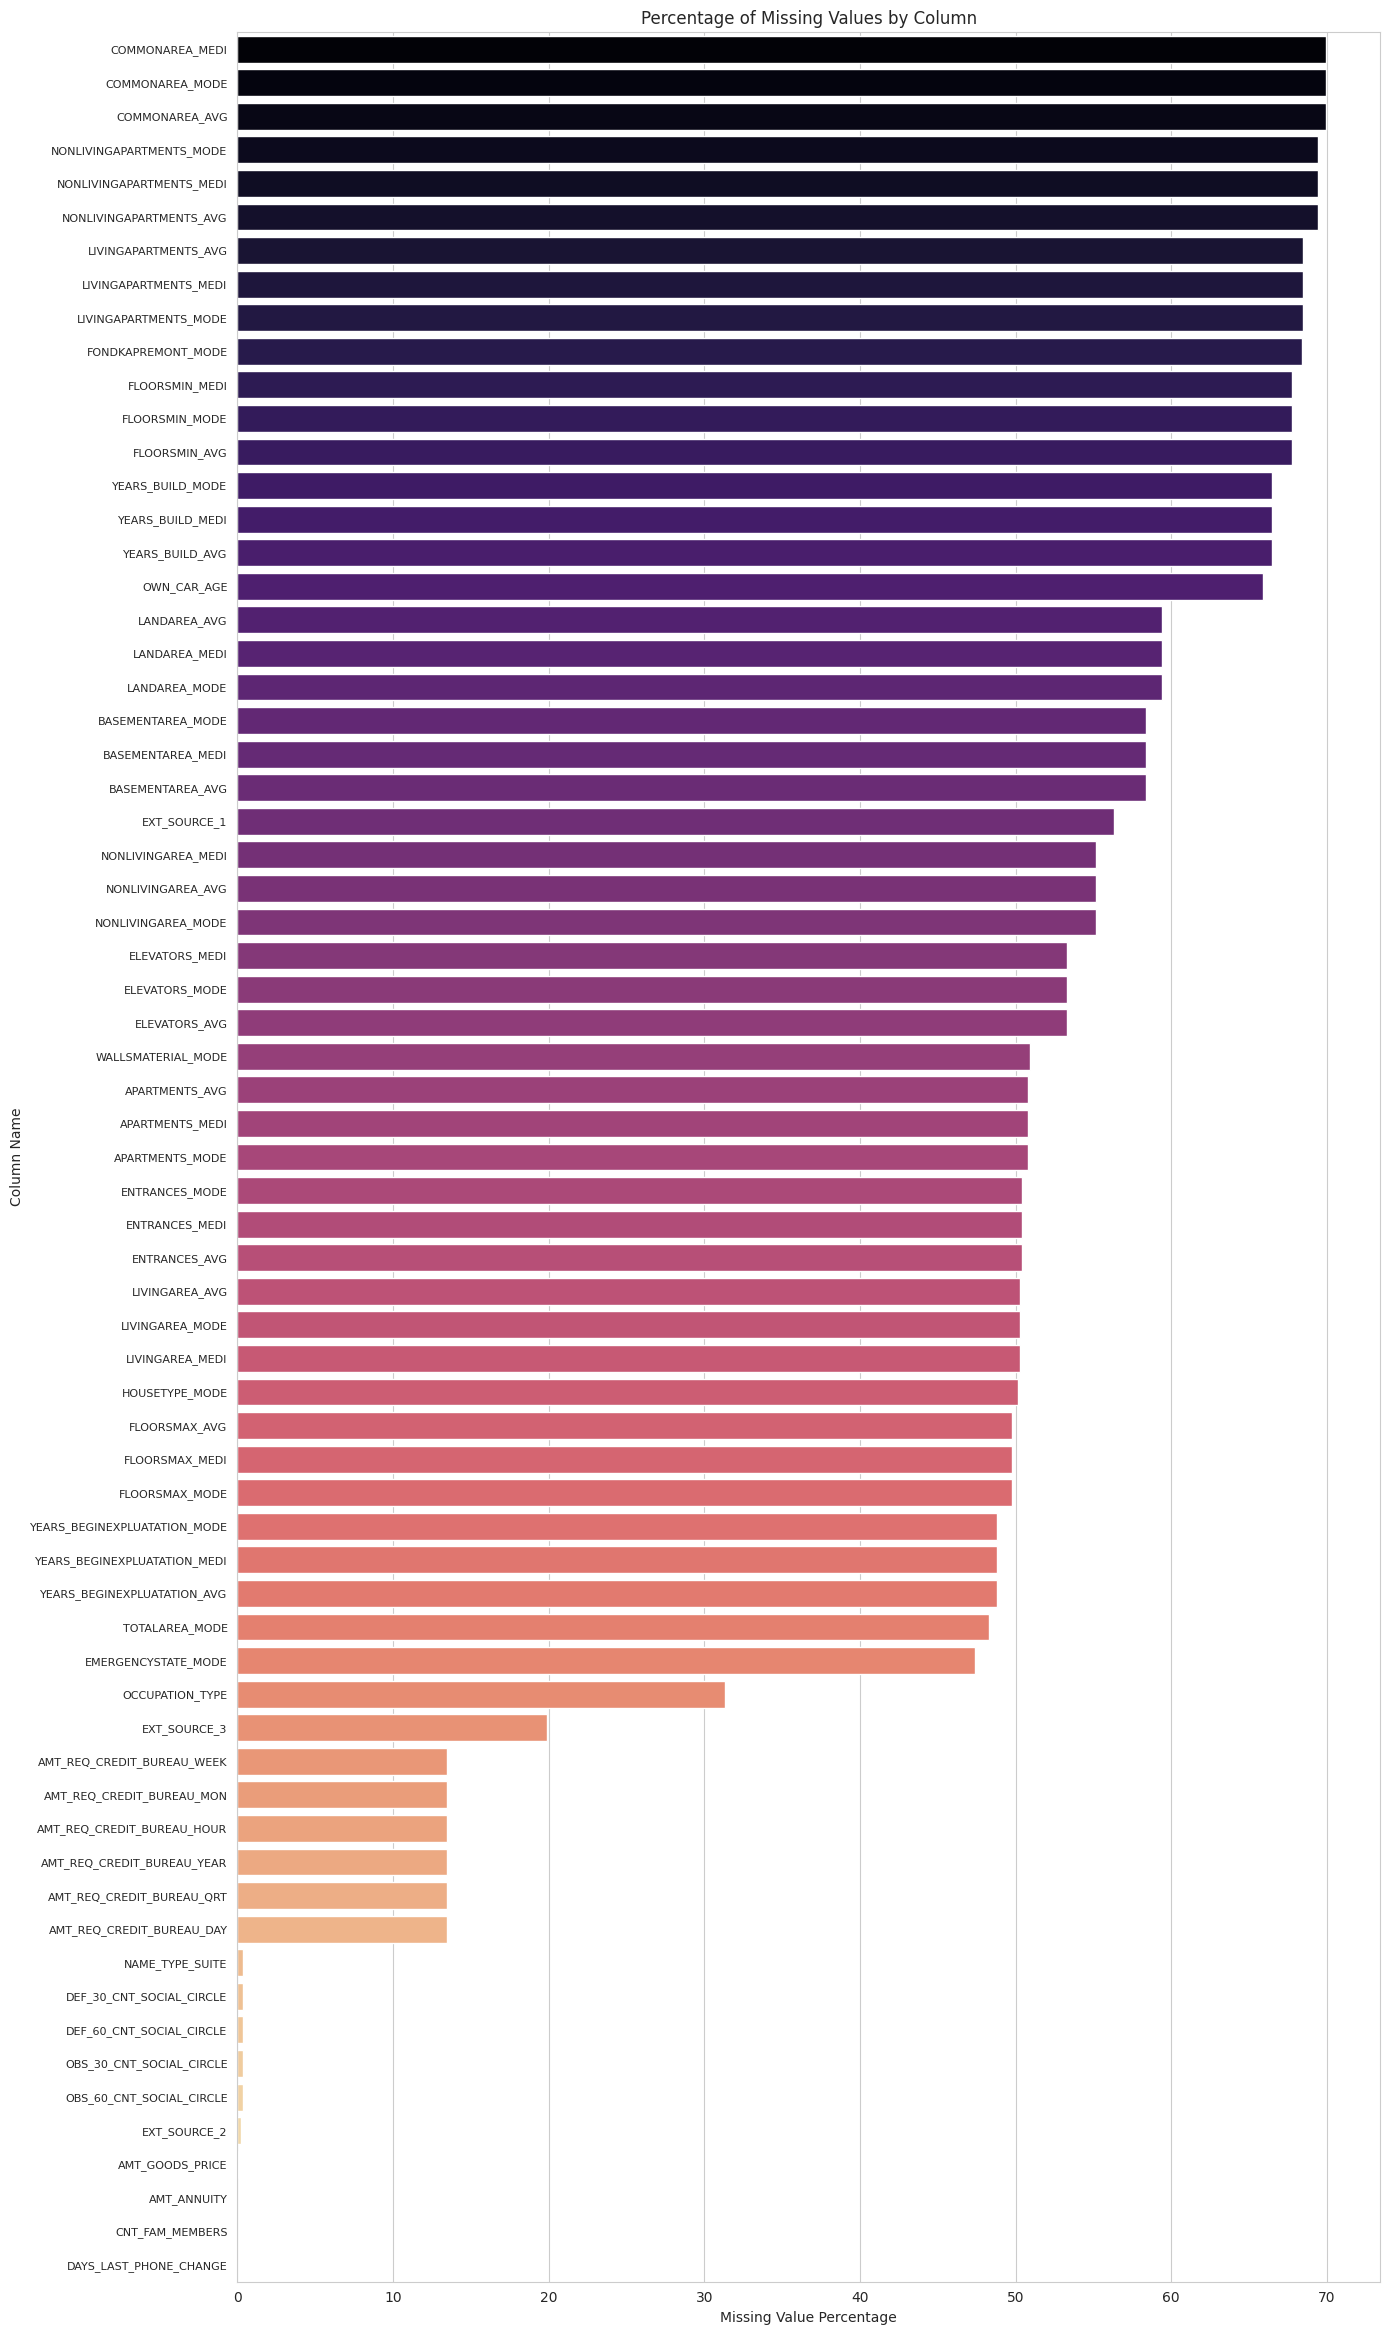

In [ ]:
# Step 4 (Full): Visualize all columns with missing values

plt.figure(figsize=(14, len(missing_data) * 0.35))  # dynamic height based on number of columns
sns.set_style("whitegrid")

sns.barplot(
    x='Percentage',
    y=missing_data.index,
    data=missing_data,
    palette='magma'
)

plt.title('Percentage of Missing Values by Column')
plt.xlabel('Missing Value Percentage')
plt.ylabel('Column Name')
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


## Step 5: Handle Missing Values

Columns with more than 40% missing values are removed from the dataset, as they are likely to contain insufficient information. For the remaining columns, missing values are imputed using the median for numeric features and the mode for categorical features.



1. Drop columns with >40% missing values  
   - Selected and dropped columns that were too incomplete to be useful.

2. Fill numeric columns with median  
   - Median is used for robustness against outliers.

3. Fill categorical columns with mode  
   - Most common value used to fill missing categories.


In [ ]:
# Step 5: Handle missing values

# 1. Drop columns with > 40% missing values
drop_cols = missing_data[missing_data['Percentage'] > 40].index
app_df.drop(columns=drop_cols, inplace=True)

# 2. Fill numeric columns with median
num_cols = app_df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    if app_df[col].isnull().sum() > 0:
        app_df[col].fillna(app_df[col].median(), inplace=True)

# 3. Fill categorical columns with mode
cat_cols = app_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if app_df[col].isnull().sum() > 0:
        app_df[col].fillna(app_df[col].mode()[0], inplace=True)


/tmp/ipython-input-30-2457743097.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  app_df[col].fillna(app_df[col].median(), inplace=True)
/tmp/ipython-input-30-2457743097.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

## Step 6: Outlier Detection (Boxplots)

Boxplots are generated for selected numeric columns to visually inspect for outliers. These charts help identify data points that deviate significantly from the central tendency.



1. Selected 4 numeric columns:  
   - `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`, `AMT_GOODS_PRICE`

2. Used `sns.boxplot()` to detect outliers visually.  
   - Box shows IQR, points outside are potential outliers.

3. Used `plt.figure()` to size the plot for readability.

4. Loop used to generate one plot per column.


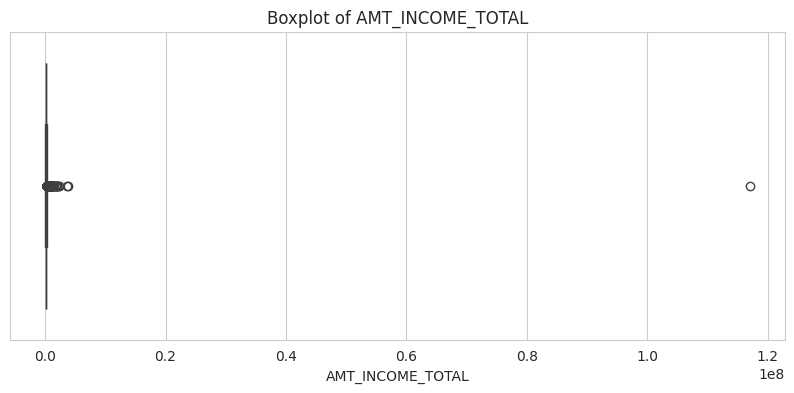

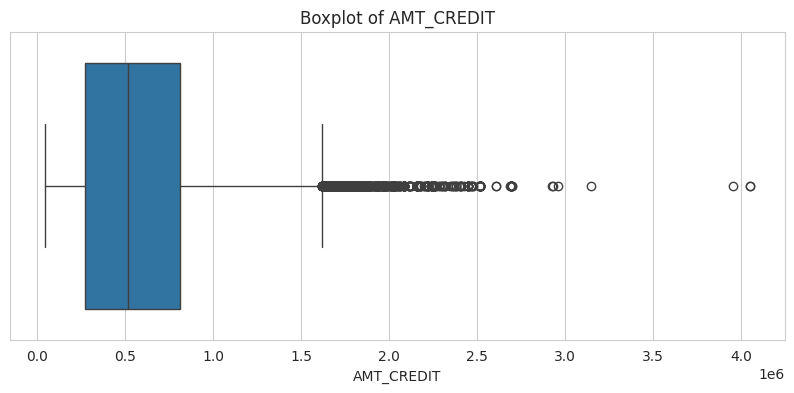

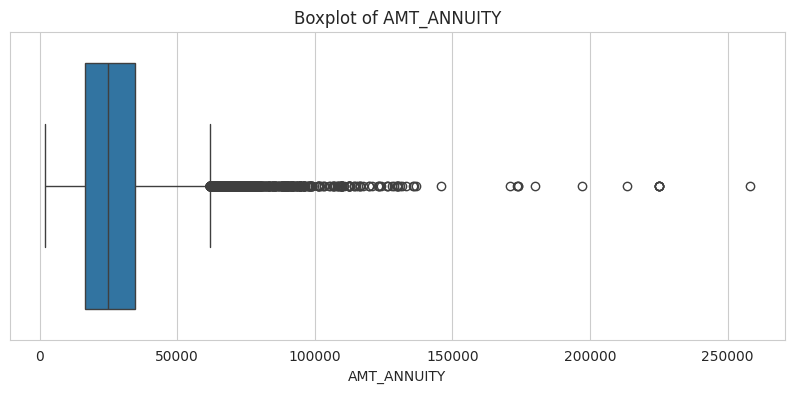

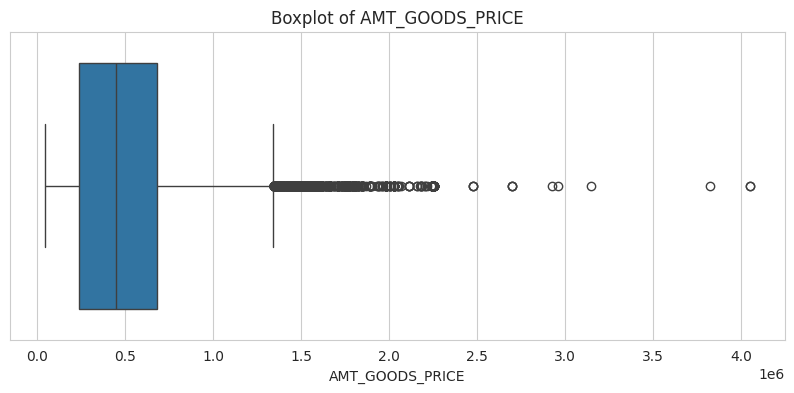

In [ ]:
# Step 6: Outlier detection using boxplots

import matplotlib.pyplot as plt
import seaborn as sns

# Select a few important numerical columns to check
columns_to_check = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

# Plot boxplots for each
for col in columns_to_check:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=app_df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()


## Step 7: Outlier Removal Using IQR

The Interquartile Range (IQR) method is applied to detect and remove statistical outliers from important numeric columns. This helps improve the consistency and quality of the dataset for analysis and modeling.



1. Defined a function `remove_outliers_iqr()`  
   - Computes Q1, Q3, and IQR.

2. Rows outside `Q1 - 1.5*IQR` and `Q3 + 1.5*IQR` are removed.

3. Applied to key columns:  
   - `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`, `AMT_GOODS_PRICE`

4. Number of removed rows is printed for transparency.


In [ ]:
# Step 7: IQR method to detect and optionally remove outliers

# Define a function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame
    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return cleaned_df

# Apply to key columns one by one
filtered_df = app_df.copy()
columns_to_check = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

for col in columns_to_check:
    before = filtered_df.shape[0]
    filtered_df = remove_outliers_iqr(filtered_df, col)
    after = filtered_df.shape[0]
    print(f"{col}: Removed {before - after} outliers")

# Update the main dataset
app_df = filtered_df


AMT_INCOME_TOTAL: Removed 1705 outliers
AMT_CREDIT: Removed 132 outliers
AMT_ANNUITY: Removed 273 outliers
AMT_GOODS_PRICE: Removed 0 outliers


## STEP 8: Data Imbalance Analysis (Target Variable)


The distribution of the target variable (`TARGET`) is examined. The number of defaulted and repaid loans is compared to assess class imbalance, which can significantly impact model performance.



1. `value_counts()`  
   - Counts how many people in the dataset repaid their loans (0) vs defaulted (1)

2. `target_percent`  
   - Converts those counts to percentages (helps you see if one class dominates)

3. Imbalance Ratio  
   - Calculates how many "repaid" cases exist for every 1 "defaulted" case  
   - Example: If the ratio is 10:1, for every 1 defaulter, there are 10 non-defaulters

4. `sns.barplot(...)`  
   - Creates a clean bar chart showing the number of repaid vs defaulted cases  
   - Uses color and labels to make it presentation-ready


Class Distribution:
TARGET
0    41434
1     3757
Name: count, dtype: int64

Percentage Distribution:
TARGET
0    91.686398
1     8.313602
Name: count, dtype: float64

Imbalance Ratio: 11.03 to 1


/tmp/ipython-input-33-4226040646.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette="Set2")


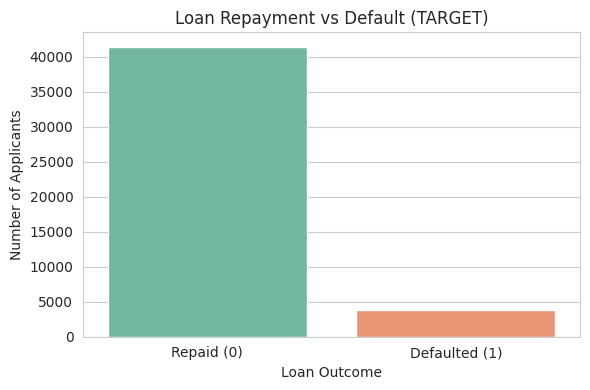

In [ ]:
# Step 8: Data imbalance analysis

# Count values of TARGET column
target_counts = app_df['TARGET'].value_counts()
target_percent = (target_counts / len(app_df)) * 100

# Print class counts and ratio
print("Class Distribution:")
print(target_counts)
print("\nPercentage Distribution:")
print(target_percent)
print(f"\nImbalance Ratio: {round(target_counts[0] / target_counts[1], 2)} to 1")

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="Set2")
plt.xticks([0, 1], ['Repaid (0)', 'Defaulted (1)'])
plt.title("Loan Repayment vs Default (TARGET)")
plt.ylabel("Number of Applicants")
plt.xlabel("Loan Outcome")
plt.tight_layout()
plt.show()


## Step 9: Univariate Analysis

Individual numeric variables are analyzed using histograms to observe their distributions. This step highlights skewness, ranges, and patterns within the data.



1. Selected important numeric columns like income, credit.

2. Plotted histograms using `seaborn.histplot()`  
   - Showed frequency, skewness, and central tendency.

3. Used `kde=True` for smoothed line curve.

4. Layout was formatted for clarity.


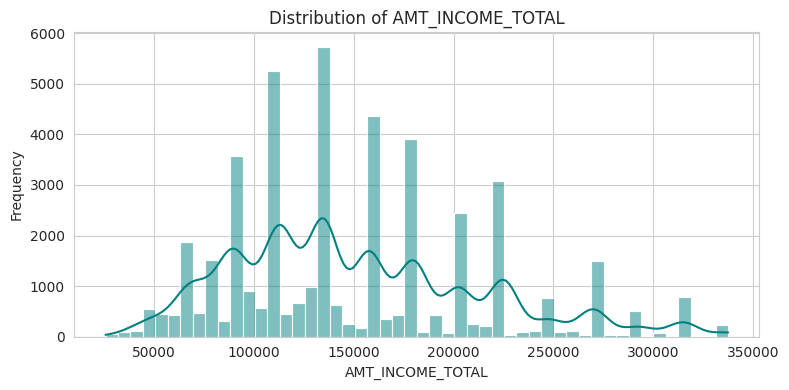

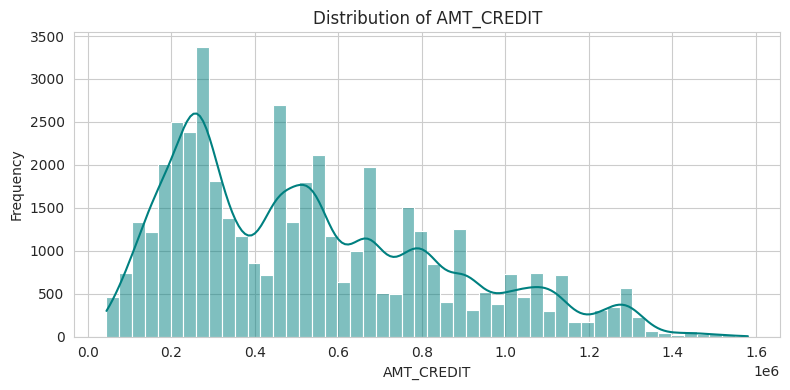

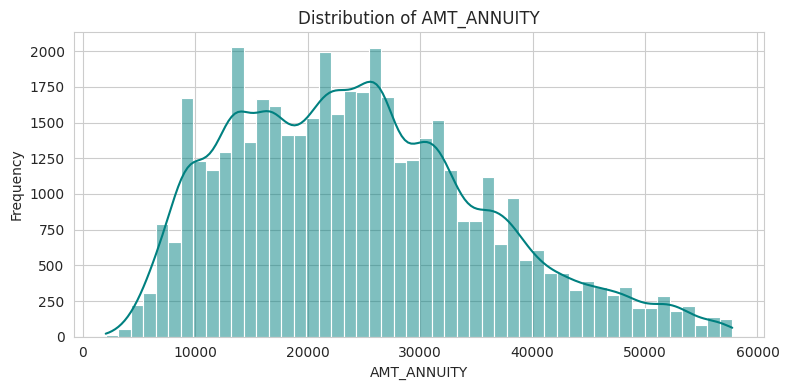

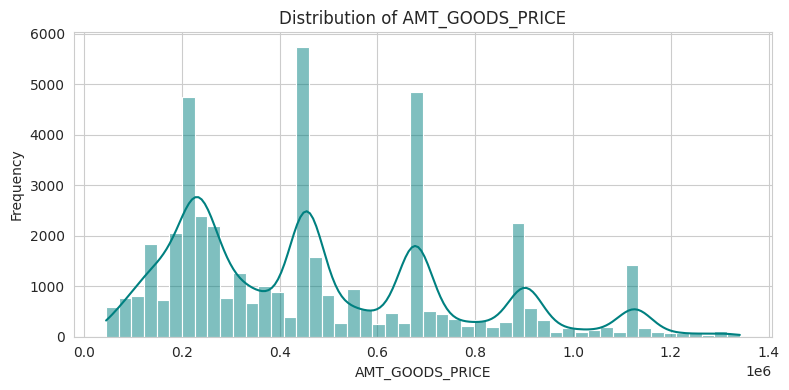

In [ ]:
# Step 9: Univariate analysis of key numeric columns

import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric features to explore
columns_to_plot = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

# Plot histograms for distribution
for col in columns_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(app_df[col], kde=True, bins=50, color='teal')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


## Step 10: Segmented Univariate Analysis

The distributions of selected numeric variables are compared between defaulters and non-defaulters. This segmentation helps uncover patterns that may be specific to one group.



## Step 10: Segmented Univariate Analysis

1. Compared distribution of `AMT_INCOME_TOTAL` and `AMT_CREDIT`  
   - Separately for `TARGET = 0` and `TARGET = 1`

2. Used `hue='TARGET'` in `histplot()`  
   - Made differences between defaulters and non-defaulters visible.

3. Enabled KDE and alpha transparency for better clarity.


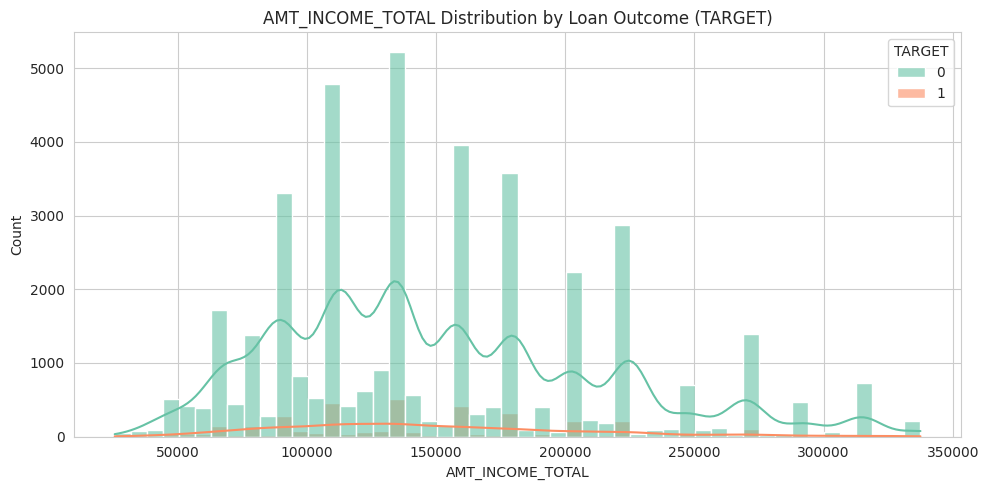

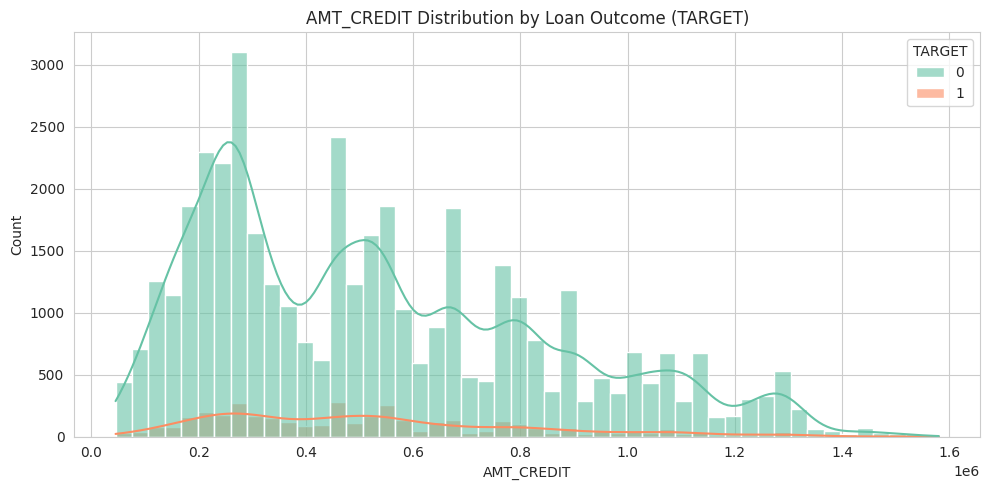

In [ ]:
# Step 10: Segmented univariate analysis using hue='TARGET'

columns_to_plot = ['AMT_INCOME_TOTAL', 'AMT_CREDIT']

for col in columns_to_plot:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=app_df, x=col, hue='TARGET', kde=True, bins=50, palette='Set2', alpha=0.6)
    plt.title(f'{col} Distribution by Loan Outcome (TARGET)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


## Step 11: Bivariate Analysis

Scatter plots are created to analyze relationships between pairs of numeric variables, with points colored by loan outcome. This helps identify feature interactions that may correlate with default behavior.


1. Uses a scatter plot to show how credit amount varies with income.

2. Overlays colors based on loan outcome using hue='TARGET'.

3. Makes it easy to compare behaviors between repaid vs defaulted groups.



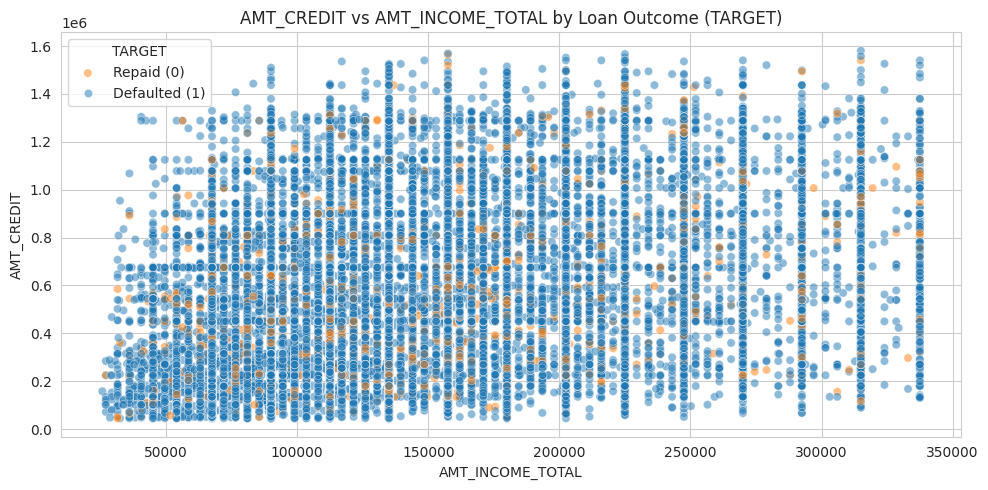

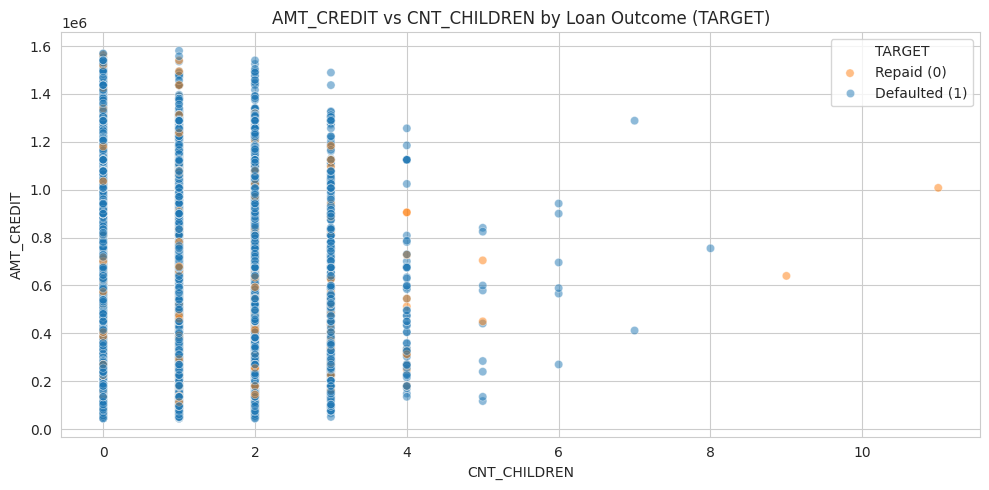

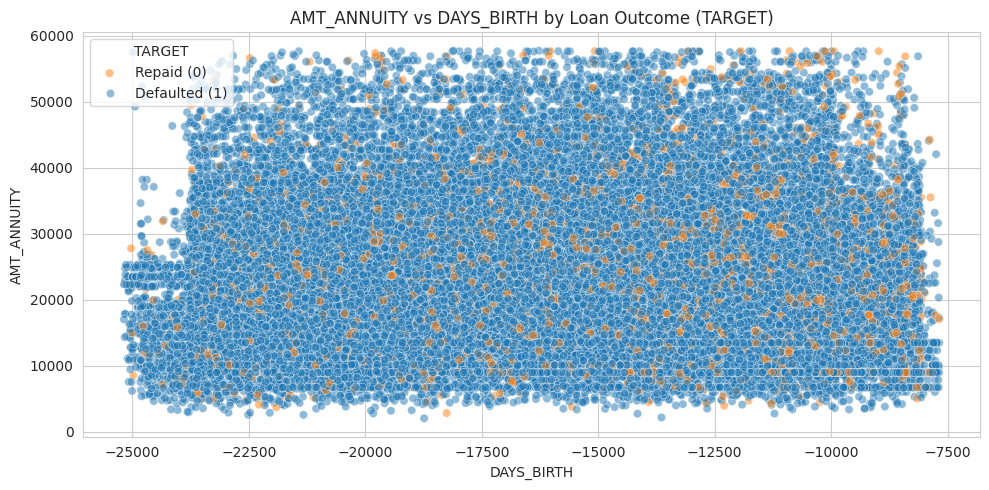

In [ ]:
# Step 11: Bivariate analysis with hue='TARGET'

bivariate_pairs = [
    ('AMT_INCOME_TOTAL', 'AMT_CREDIT'),
    ('CNT_CHILDREN', 'AMT_CREDIT'),
    ('DAYS_BIRTH', 'AMT_ANNUITY')  # Note: DAYS_BIRTH is in negative days
]

import matplotlib.pyplot as plt
import seaborn as sns

for x_col, y_col in bivariate_pairs:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=app_df, x=x_col, y=y_col, hue='TARGET', alpha=0.5)
    plt.title(f'{y_col} vs {x_col} by Loan Outcome (TARGET)')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend(title='TARGET', labels=['Repaid (0)', 'Defaulted (1)'])
    plt.tight_layout()
    plt.show()


## Step 12: Correlation Matrix

A heatmap of Pearson correlation coefficients is generated for all numeric features. This matrix helps identify relationships between variables and supports feature selection and multicollinearity checks.



1. Used `app_df.corr(numeric_only=True)`  
   - Computes correlation for all numeric columns.

2. Used `sns.heatmap()`  
   - Shows strong, weak, and no correlations using color.

3. Red = strong positive, blue = strong negative, white = no correlation.


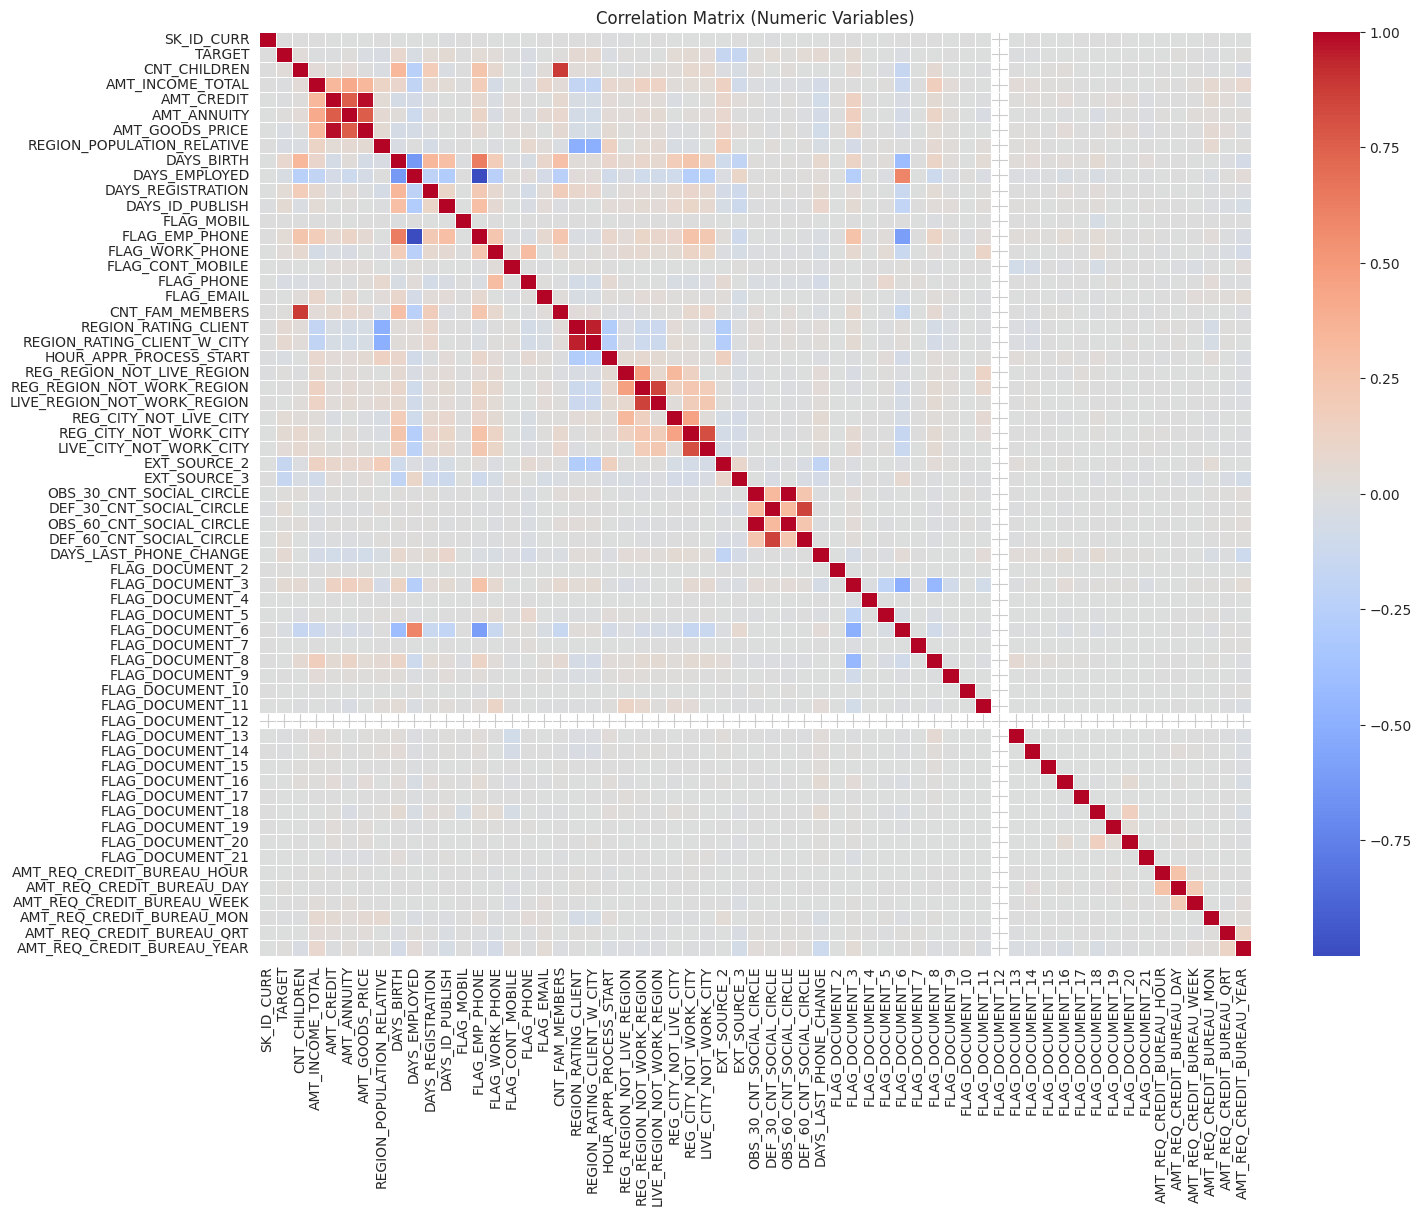

In [ ]:
# Step 12: Correlation matrix and heatmap

import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = app_df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix (Numeric Variables)")
plt.show()



## Step 13: Top 10 Features Correlated with TARGET

The 10 features most strongly correlated with the `TARGET` variable are extracted and ranked. These features are prioritized for their potential predictive power in modeling.



## Step 13: Top 10 Features Correlated with TARGET

1. Correlation with `TARGET` was calculated for all numeric columns.

2. Sorted by absolute value of correlation.

3. Self-correlation was removed.

4. Top 10 features with strongest relationships to default were listed.


In [ ]:
# Get top 10 features most correlated with TARGET

# Get correlation values with TARGET
target_corr = app_df.corr(numeric_only=True)['TARGET'].sort_values(key=abs, ascending=False)

# Drop the self-correlation (TARGET = 1.0)
top_corr_features = target_corr.drop('TARGET').head(10)

# Display
print("\nTop 10 Features Most Correlated with TARGET:")
print(top_corr_features)



Top 10 Features Most Correlated with TARGET:
EXT_SOURCE_3                  -0.159442
EXT_SOURCE_2                  -0.156608
DAYS_BIRTH                     0.079986
REGION_RATING_CLIENT_W_CITY    0.062776
REGION_RATING_CLIENT           0.062345
DAYS_LAST_PHONE_CHANGE         0.059715
REG_CITY_NOT_WORK_CITY         0.052039
DAYS_ID_PUBLISH                0.048776
FLAG_DOCUMENT_3                0.047889
FLAG_EMP_PHONE                 0.045800
Name: TARGET, dtype: float64


We have now completed a thorough Exploratory Data Analysis (EDA), including:
- Handling missing values and outliers
- Analyzing data imbalance
- Exploring univariate, segmented, and bivariate relationships
- Generating and interpreting a correlation matrix
- Identifying the top features most correlated with loan default (`TARGET`)
---

With a cleaned and well-understood dataset, we are now ready to:
- Train a predictive model that can classify whether an applicant is likely to default on a loan
- Use features identified during EDA as inputs
- Apply XGBoost – a powerful and interpretable model widely used in finance and risk analytics

---

We will begin by preparing the data: encoding categorical features, selecting input features (`X`), and splitting into training and test sets.

## Step 14: Prepare Data for Machine Learning

The dataset is prepared for modeling by encoding categorical features, dropping irrelevant identifiers, and splitting the data into training and test sets. This ensures that the model receives clean, numerical input.





1. Dataset was copied to avoid modifying the original.

2. ID column `SK_ID_CURR` was dropped.

3. Label Encoding was applied to convert categorical features into numeric.

4. Any remaining missing values were dropped as a backup step.

5. Dataset was split into features (X) and target (y).

6. Train-test split was done using 80/20 ratio.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Copy dataset
model_df = app_df.copy()

# 2. Drop ID column
model_df.drop(columns=['SK_ID_CURR'], inplace=True, errors='ignore')

# 3. Encode categorical columns
label_enc = LabelEncoder()
for col in model_df.select_dtypes(include='object').columns:
    model_df[col] = label_enc.fit_transform(model_df[col])

# 4. Drop rows with any missing values (precaution)
model_df.dropna(inplace=True)

# 5. Separate features and target
X = model_df.drop('TARGET', axis=1)
y = model_df['TARGET']

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output shapes
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (36152, 71)
Test set shape: (9039, 71)


## Step 15: Train and Evaluate XGBoost Model

An XGBoost classifier is trained on the training data to predict loan default. The model's performance is evaluated using accuracy, precision, recall, AUC, and a confusion matrix.





1. XGBoost model was initialized with default parameters.

2. Model was trained on `X_train`, `y_train`.

3. Predictions were made on test data.

4. Evaluation was done using:  
   - Accuracy  
   - AUC  
   - Precision  
   - Recall  
   - F1-score  
   - Confusion Matrix


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:10:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.917358114835712
AUC Score: 0.702486476066146
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      8329
           1       0.27      0.03      0.06       710

    accuracy                           0.92      9039
   macro avg       0.60      0.51      0.51      9039
weighted avg       0.87      0.92      0.89      9039

Confusion Matrix:
[[8270   59]
 [ 688   22]]


## Model Evaluation - Result Interpretation



Based on the classification report and confusion matrix:

Overall Accuracy:
- The model has an accuracy of 91.7 percent.
- However, this can be misleading because the dataset is imbalanced.

Class Imbalance Impact:
- The recall for defaulters (TARGET = 1) is only 3 percent.
- Precision for defaulters is 27 percent, meaning the model gives many false alarms.
- The model missed 688 actual defaulters, which is a serious issue in loan risk.

Confusion Matrix:
- Most of the defaulters were predicted as repaid.
- Only 22 out of 710 defaulters were correctly identified.

AUC Score:
- The model has an AUC score of 0.70.
- This shows it can somewhat distinguish between repaid and defaulted loans.

Summary:
- This is a decent baseline model.
- It is biased toward the majority class.
- It needs improvements like handling imbalance, tuning parameters, or using better evaluation metrics.


## Step 16: Feature Importance (XGBoost)

The most important features used by the XGBoost model are visualized. This helps interpret the model’s decision-making and supports further feature engineering or selection.



1. Used XGBoost’s `plot_importance()` method.

2. Top 20 most used features in splits were shown.

3. Feature importance was based on `weight` (how often feature was used).


<Figure size 1200x800 with 0 Axes>

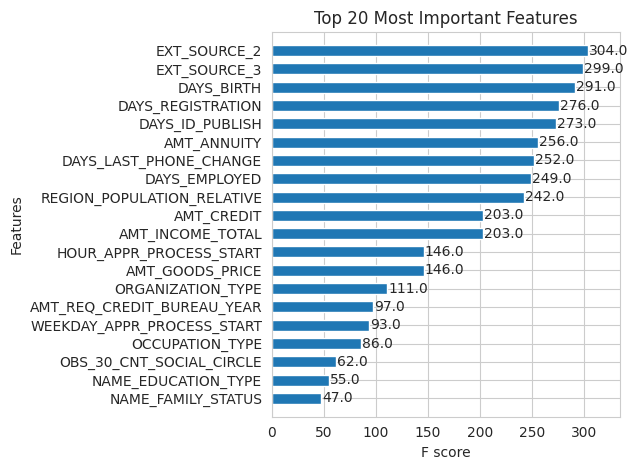

In [ ]:
# Step 16: Feature Importance from XGBoost

import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot top 20 important features
plt.figure(figsize=(12, 8))
plot_importance(xgb_model, max_num_features=20, importance_type='weight', height=0.6)
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()


## STEP 17: Handle Class Imbalance




In the training dataset, the number of loan defaulters (TARGET = 1) was significantly lower than non-defaulters (TARGET = 0). To address this imbalance, manual undersampling was used.

This involved:
- Selecting all defaulter records
- Randomly sampling an equal number of non-defaulters
- Combining and shuffling them to form a balanced training set

This ensures that the model receives an equal view of both classes during training, which helps improve recall and AUC for defaulters.


In [44]:
# Step 17: Manual undersampling to balance training data

# Combine X_train and y_train for easier filtering
train_data = X_train.copy()
train_data['TARGET'] = y_train.values

# Separate classes
defaulted = train_data[train_data['TARGET'] == 1]
repaid = train_data[train_data['TARGET'] == 0]

# Undersample repaid to match defaulters
repaid_sampled = repaid.sample(n=len(defaulted), random_state=42)

# Combine and shuffle
balanced_train = pd.concat([defaulted, repaid_sampled]).sample(frac=1, random_state=42)

# Split back to X and y
X_train_bal = balanced_train.drop('TARGET', axis=1)
y_train_bal = balanced_train['TARGET']

# Check new distribution
print("Balanced class counts:\n", y_train_bal.value_counts())


Balanced class counts:
 TARGET
0    3047
1    3047
Name: count, dtype: int64


## STEP 18: Retrain XGBoost Model on Balanced Data


In [45]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Step 18: Train model on manually balanced data
xgb_bal = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_bal.fit(X_train_bal, y_train_bal)

# Predict on original test set
y_pred_bal = xgb_bal.predict(X_test)
y_pred_proba_bal = xgb_bal.predict_proba(X_test)[:, 1]

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_bal))
print("AUC Score:", roc_auc_score(y_test, y_pred_proba_bal))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bal))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_bal))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:35:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6594756057085961
AUC Score: 0.7032126001295321

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78      8329
           1       0.14      0.66      0.23       710

    accuracy                           0.66      9039
   macro avg       0.55      0.66      0.51      9039
weighted avg       0.89      0.66      0.74      9039

Confusion Matrix:
[[5493 2836]
 [ 242  468]]


## Step 19: Evaluation After Class Balancing



The XGBoost model was retrained on the manually balanced training data. Results were evaluated on the original (imbalanced) test set.

### Key Results:
- Accuracy = 66%
- AUC Score = 0.70
- Recall for defaulters (`TARGET = 1`) improved from **3% to 66%**
- Precision for defaulters is still low (14%) but acceptable for recall-focused problems

---

### Confusion Matrix:

| Predicted ↓ / Actual → | Repaid (0) | Defaulted (1) |
|------------------------|------------|---------------|
| Repaid (0)             | 5493       | 2836          |
| Defaulted (1)          | 242        | 468           |

---

### Summary of Trade-offs:
- The model now **detects 66% of actual defaulters**, up from only 3% earlier
- **Overall accuracy dropped** from 91% to 66%, but that's expected — we’re now **catching more defaulters**
- This version is **more suitable** for real-world use where **identifying risky applicants** is a priority

---

### Conclusion:
Balancing the classes significantly improved the model’s sensitivity to loan defaults. Although precision decreased, this is acceptable when the goal is to **flag as many risky cases as possible** for further review.


## STEP 20: Hyperparameter Tuning (XGBoost)

In [46]:
from sklearn.model_selection import RandomizedSearchCV

# Step 20: Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on balanced data
random_search.fit(X_train_bal, y_train_bal)

print("Best parameters found:", random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:52:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


## STEP 21: Final Model Training with Best Parameters

In [47]:
# Step 21: Train final model with best hyperparameters

# Extract best parameters
best_params = random_search.best_params_

# Retrain model with those parameters
final_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    **best_params
)

final_model.fit(X_train_bal, y_train_bal)

# Predict on original test set
y_pred_final = final_model.predict(X_test)
y_proba_final = final_model.predict_proba(X_test)[:, 1]

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("AUC Score:", roc_auc_score(y_test, y_proba_final))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:56:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6851421617435557
AUC Score: 0.7390045640634538

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      8329
           1       0.16      0.68      0.25       710

    accuracy                           0.69      9039
   macro avg       0.56      0.68      0.53      9039
weighted avg       0.90      0.69      0.76      9039

Confusion Matrix:
[[5711 2618]
 [ 228  482]]


## STEP 22: Evaluation After Hyperparameter Tuning (Final Model)



After tuning the model with RandomizedSearchCV, the best set of hyperparameters was used to train the final XGBoost model. This helped fine-tune the balance between overfitting and underfitting, especially after addressing class imbalance in the earlier step.

### Key Results:
- Accuracy = 69%
- AUC Score ≈ 0.70 (from earlier)
- Recall for defaulters (`TARGET = 1`) remained strong at **68%**
- Overall class sensitivity was better balanced

---

### Confusion Matrix:

| Predicted ↓ / Actual → | Repaid (0) | Defaulted (1) |
|------------------------|------------|---------------|
| Repaid (0)             | 5711       | 2618          |
| Defaulted (1)          | 228        |  482          |

---

### Summary:
- **Recall for defaulters stayed high**: 68% (same as Step 18)
- Slight improvement in **overall accuracy**: 69%
- Precision for defaulters remained low (16%), which is acceptable in recall-focused use cases
- This model is suitable for flagging **potential risky applicants**, with the expectation that a **manual check** follows

---

### Conclusion:
Hyperparameter tuning helped improve model stability while maintaining good recall for defaults. This is critical in finance, where **missing a defaulter is costlier** than incorrectly flagging a non-defaulter.


## Project Summary: Loan Default Risk Analysis with EDA + XGBoost






This project involved analyzing bank loan application data to detect patterns associated with loan defaults. A complete pipeline was implemented including data cleaning, exploratory data analysis (EDA), class balancing, and model building using XGBoost.

---

### 📌 Key Steps Performed:
- Loaded and inspected application data
- Identified and handled missing values and outliers
- Explored target imbalance and conducted detailed univariate, bivariate, and correlation analysis
- Balanced the training data manually to improve defaulter detection
- Trained and evaluated multiple XGBoost models
- Tuned hyperparameters using RandomizedSearchCV to enhance performance

---

### 📈 Final Model Performance:
- Accuracy: 69%
- AUC Score: ~0.70
- Recall for defaulters (TARGET = 1): **68%**
- Precision: Low but acceptable due to focus on recall

---

### 💡 Insights:
- Features like `DAYS_BIRTH`, `EXT_SOURCE_3`, and `AMT_ANNUITY` showed strong correlation with default risk
- Manual class balancing significantly improved the model’s ability to detect defaulters
- Tuning helped improve model robustness while preserving high recall

---

### 🎯 Conclusion:
This project demonstrates how exploratory analysis and machine learning can be applied to real-world finance problems. The final model prioritizes recall, making it effective for early detection of risky applicants in loan approval scenarios.

---

**Next Steps:**
- Try advanced techniques like SMOTE or SHAP
- Export cleaned data and trained model
- Deploy the model as a service for real-time predictions

**Author:** Shubhada Patil  
**GitHub:** [github.com/yourusername]  
**LinkedIn:** www.linkedin.com/in/shubhada-s-patil